In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

This video is based on the simulation from https://www.youtube.com/watch?v=iSEAidM-DDI so be sure to check that video out. It should be regarded as a prerequisite to this video.

# Brief Review

We can give random positions to particles:

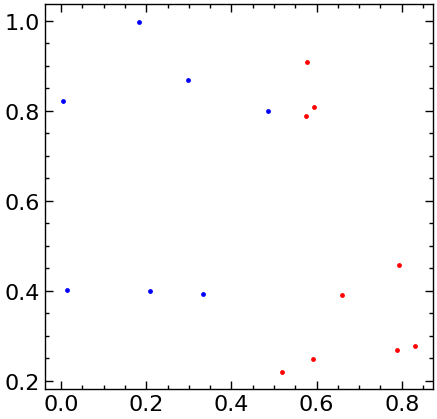

In [6]:
n_particles = 16
r = torch.rand((2,n_particles)).to(device)
# Color particles the start on either side
ixr = r[0]>0.5 #right
ixl = r[0]<=0.5 #left

plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(),r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(),r[1][ixl].cpu(), color='b', s=6)

We assign each of the initial velocities to be +500m/s (blue) or -500m/s (red)

In [7]:
v = torch.zeros((2,n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] = 500

By assigning each particle a unique ID, we can track the distance between all pairs:

In [8]:
ids = torch.arange(n_particles)

In [12]:
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids,2).to(device)

We can use these "paired" ids to get $(x_i, x_j)$ and $(y_i,y_j)$ 

In [15]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T

Then we can compute the distance $\Delta r_{ij}=\sqrt{(x_i-x_j)^2+(y_i-y_j)^2}$ for all pairs

In [20]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)

These distances can be used to determine whether or not particles collide (look for $d=2R$ where $R$ is the particle radius).

In [23]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  6],
        [ 0, 11],
        [ 2,  6],
        [ 2, 11],
        [ 3, 14],
        [ 6, 11],
        [10, 12]], device='cuda:0')

Then we can modify their velocities based on

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [27]:
v1 = v[:,ids_pairs_collide[:,0]]
v2 = v[:,ids_pairs_collide[:,1]]
r1 = r[:,ids_pairs_collide[:,0]]
r2 = r[:,ids_pairs_collide[:,1]]
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

We then run a simulation where $\vec{r}^{(i+1)} = \vec{v}^{(i)}  \Delta t$ and we change velocities if an only if particles collide, or if they hit the edges of the box

* This is important for this simulation. If they hit the edges of the box, an *elastic* collision is assumed, and a component of the particles velocity gets reversed. For example, if a particle hit the side of the box located at +X, the particles $v_x$ component would flip signs.

In [30]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, ids_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = ids_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = r
    return rs, vs

In [31]:
N = 3000
dt = 8e-6
t_steps = 2000
v0 = 500
L = 1
r = torch.rand((2,N)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(N)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((2,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs = motion(r, v, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

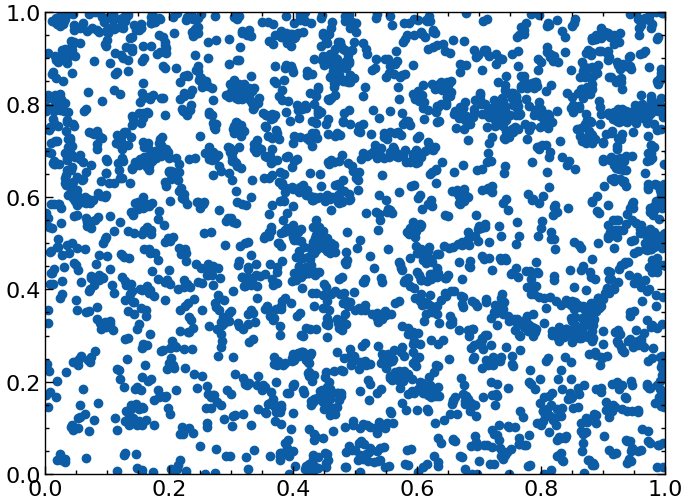

In [37]:
plt.scatter(*rs[471].cpu())
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

# Ideal Gas Law

We essentially want to show that

$$PV = Nk_B T$$

where $P$ is pressure, $V=L^3$ is the volume of a box, $N$ is the number of particles, and $k_B$ is Boltzmann's constant. Noting that $E = 3/2 k_B T$ (kinetic theory of gases) we can write $1/2 m v_{average}^2 = 3/2 k_B T$ or that

$$T = \frac{m}{3k_B}v_{average}^2$$

Since no energy is lost, $v_{average}$ will remain the same throughout the simulation (note we assume that all particles have same mass $m$ here). We can rewrite the right hand side (RHS) of the ideal gas law as

$$RHS = \frac{Nm}{3}v_{average}^2$$

In our billiard ball simulation, the RHS can be computed based on the initial state. We choose the number of particles $N$ and initial velocities $v$ and this can be computed. The purpose of the simulation will be to show that the $RHS$ is equal to $PV$ (which is computed based on balls hitting walls).

 The pressure is given by $P = F/(6L^2)$ where $F$ is the force and $L$ is the side length of the box. We just need to compute the imparted force. Noting that $F = \Delta p / \Delta t$, we can compute the force as follows:

 * We track particles that hit the walls of the box and compute the change of momentum $\Delta p_i$ given to the box at each time step.
 * The force is then $F = \sum_i |\Delta p_i| / t$ where $t$ is the length of time of the simulation.
 * Note that $p_i = mv_i$

 We can substitute this into $P$ and set $V=L^3$ to get

 $$LHS = \frac{mL \sum |\Delta v_i|}{6 \Delta t}$$

 So if we compute $RHS$ at the beginning of the simulation, run the simulation, and show that $LHS$ is equal, then we have effectively provided Monte Carlo based evidence for the ideal gas law. Since both are proportional to mass, we'll neglect $m$ and simply show that  $LHS/m = RHS/m$



In [38]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    dz = torch.diff(torch.stack([r[2][ids_pairs[:,0]], r[2][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2 + dz**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, L, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, *r.shape)).to(device)
    vs = torch.zeros((ts, *v.shape)).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    dv = torch.zeros(ts).to(device)
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, id_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        # NEW STUFF
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>L])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]>L]))
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        dv[i] += 2*torch.sum(torch.abs(v[0,r[0]<0]))
        v[1,r[1]>L] = -torch.abs(v[1,r[1]>L])
        dv[i] += 2*torch.sum(torch.abs(v[1,r[1]>L]))
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        dv[i] += 2*torch.sum(torch.abs(v[1,r[1]<0]))
        v[2,r[2]>L] = -torch.abs(v[2,r[2]>L])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]>L]))
        v[2,r[2]<0] = torch.abs(v[2,r[2]<0])
        dv[i] += 2*torch.sum(torch.abs(v[2,r[2]<0]))
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs, dv

In [39]:
N = 3000
dt = 8e-6
t_steps = 2000
t = np.arange(t_steps)*dt
v0 = 500
L = 1
r = torch.rand((3,N)).to(device)
ixr = r[0]>0.5 
ixl = r[0]<=0.5 
ids = torch.arange(N)
ids_pairs = torch.combinations(ids,2).to(device)
v = torch.zeros((3,N)).to(device)
v[0][ixr] = -v0
v[0][ixl] = v0
radius = 0.005
rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)

First, lets take a look at the change in velocity $|\Delta v_i|$ induced by the particles hitting the walls:

Text(0, 0.5, '$\\Delta v_i$ [m/s]')

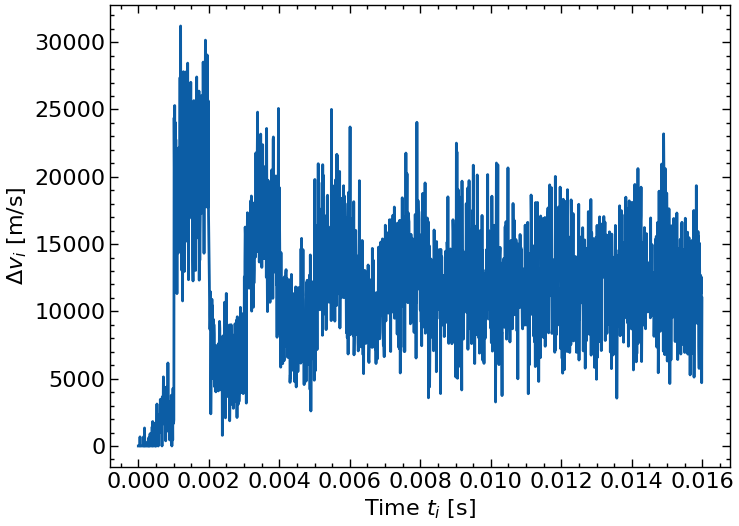

In [40]:
plt.plot(t, dv.cpu())
plt.xlabel(r'Time $t_i$ [s]')
plt.ylabel(r'$\Delta v_i$ [m/s]')

Since the particles are initially moving either left or right at 500m/s, pressure only gets exerted on the wall when they all reach the wall. Over time, the gas particles get distributed according to the Boltzmann distribution and the pressure becomes more constant

So we'll compute the LHS and RHS using only the last 1000 points of the simulation (when the gas has reached its Boltzmann distribution state)

In [41]:
n_points = 1000
LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
print(LHS.item())

248995552.0


In [42]:
RHS = N / 3 * v0**2
print(RHS)

250000000.0


These numbers, being very close, provide evidence for the ideal gas law the pressure is $P \propto T$. We can do multiple simulations and plot the following equation. Noting that the LHS is equal to $PV$ and the RHS is equal to $Nk_BT$ we can change the values of $v_0$ and show a linear relationship:

In [43]:
def run_simulation(N, v0, L, radius=0.005, n_points = 1000, t_steps=4000):
    dt = 8e-6
    r = torch.rand((3,N)).to(device)
    ixr = r[0]>0.5 
    ixl = r[0]<=0.5 
    ids = torch.arange(N)
    ids_pairs = torch.combinations(ids,2).to(device)
    v = torch.zeros((3,N)).to(device)
    v[0][ixr] = -v0
    v[0][ixl] = v0
    rs, vs, dv = motion(r, v, L, ids_pairs, ts=t_steps, dt=dt, d_cutoff=2*radius)
    LHS = torch.sum(dv[-n_points:]) / (6 * L**2 * dt * n_points)
    RHS = N / 3 * v0**2
    return LHS.item(), RHS

Now lets run different simulations for different values of $v_0$

In [44]:
v0s = [300, 500, 700, 900]
LHSs = []
RHSs = []
for v0 in v0s:
    LHS, RHS = run_simulation(N=3000, v0=v0, L=1)
    LHSs.append(LHS)
    RHSs.append(RHS)

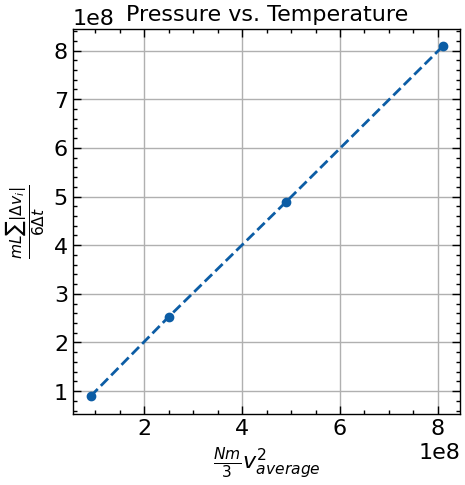

In [45]:
plt.figure(figsize=(5,5))
plt.plot(RHSs, LHSs, 'o--')
plt.title('Pressure vs. Temperature')
plt.xlabel(r'$\frac{Nm}{3}v_{average}^2$')
plt.ylabel(r'$\frac{mL \sum |\Delta v_i|}{6 \Delta t}$')
plt.grid()
plt.show()

## Exercise For Viewers
In this video, we showed the $P \propto T$. This code can be modified to show other results. For example, you can show

* $P \propto 1/V$. This requires rearranging $PV = Nk_BT$ to get $1/V$ on one side, and another quantity on the other side. Then one can vary $V$ and see how the other side of the equation changes (requires changing $L$ in simulation above)
* $P$ is independent of radius. Just try different values of particle radius and show the simulation results don't change.
* $P \propto N$. Again, rearrange the equation to get $N$ on one side (computed using initial state) and another quantity on the other side (computed based on simulation) and plot $P$ "equivalent" vs $N$ "equivalent".